# Data Exploration 

## Data Loading

In [12]:
import pandas as pd
import seaborn as sns
from collections import Counter
import matplotlib.pyplot as plt

def remove_empty(text):
    return [lab for lab in text if lab != '']

def remove_space(text):
    return [lab.strip() for lab in text]

df = pd.read_csv('../input/Evaluation-dataset.csv',header = None)
df = df.fillna('')
columns = ['text']
labels = []
for idx in range(1, 15):
    name = 'label_' + str(idx)
    labels.append(name)
    columns.append(name)

df.columns = columns
df['target'] = df[labels].values.tolist()
df['target'] = df['target'].map(remove_empty)
df['target'] = df['target'].map(remove_space)
df =  df[['text','target']]
df["target_counts"] = df["target"].apply(lambda label: len(label))
print("There are {} Rows in Data".format(df.shape[0]))


There are 10132 Rows in Data


## Distribution of Count of Labels per Datapoint

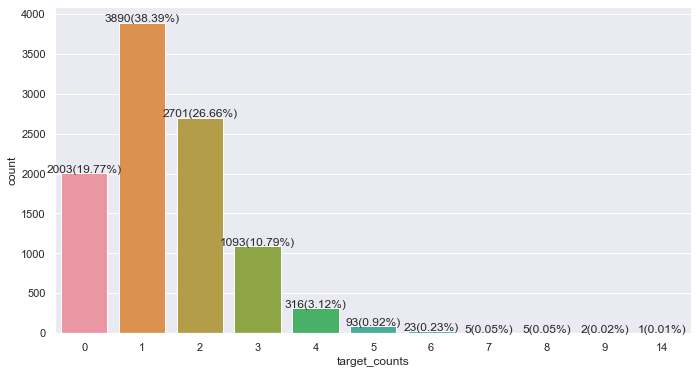

In [2]:
sns.set(rc={'figure.figsize':(11.4,6.00)})
ax=sns.countplot(df.target_counts)
for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x()+p.get_width()/2.,
            height + 3,
            '{}({:1.2f}%)'.format(height,(height/len(df.target_counts))*100),
            ha="center") 

#### There are 2003 datapoints that doesn't have any labels and most of the datapoints have less than or equal to 4 labels and one datapoint have 14 labels and that is an outlier so we will remove it

In [3]:
df[df.target_counts == 14]

,text,target,target_counts
384,"test review, should be deleted","[refund not actioned positive, refund timescal...",14


#### As we can see this datapoint is just for testing so we can easily drop it 

In [4]:
df = df.drop([384])
print("Shape of dataframe after removing outlier datapoint {}".format(df.shape))


Shape of dataframe after removing outlier datapoint (10131, 3)


In [5]:
print("Number of Unique labels - {}".format(len(df.target.explode().unique())))


Number of Unique labels - 99


In [6]:
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', -1)
pd.DataFrame.from_dict(dict(df.target.explode().value_counts()),orient = 'index',columns = ['Count'])

,Count
value for money positive,4780
garage service positive,2031
ease of booking positive,1187
location positive,1063
length of fitting positive,657
delivery punctuality positive,453
tyre quality positive,434
garage service negative,423
change of date negative,277
wait time positive,274


#### There are 99 unique labels in the dataset but alot of the labels doesn't have any sentiment assosiated with it and also available in very low counts so we can simpy consider those as noise and can remove them.

In [7]:
def get_noisy_labels(df):
    noisy_labels = []
    for label,count in Counter(df.target.explode()).items():
        if count < 5:
            if 'positive' not in label.split():
                if 'negative' not in label.split():
                    noisy_labels.append(label)
    return noisy_labels

# to remove nosiy labels from the dataframe
def remove_noisy_labels(df):
    #print("Removing noisy labels...")
    noisy_labels = get_noisy_labels(df)
    print("Number of Noisy Labels - {}".format(len(noisy_labels)))
    for i in range(len(df)):
        for nLabel in noisy_labels:
            if nLabel in df.iloc[i,1]:
                df.iloc[i,1].remove(nLabel)
    
    # to remove datapoints that doesn't have any labels 
    df = df[df["target"].str.len() != 0]

    return df 

df = remove_noisy_labels(df)


Number of Noisy Labels - 44


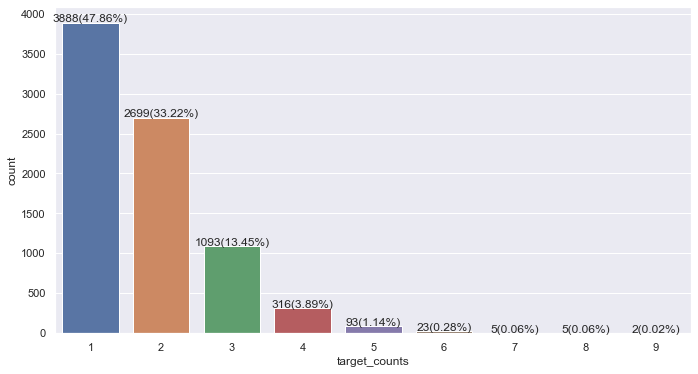

In [8]:
ax=sns.countplot(df.target_counts)
for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x()+p.get_width()/2.,
            height + 3,
            '{}({:1.2f}%)'.format(height,(height/len(df.target_counts))*100),
            ha="center") 


#### So we have removed datapoints that have 0 labels and also some noisy labels that have no sentiments assosiated with it

In [9]:
print("Number of Unique labels after removing noisy labels - {}".format(len(df.target.explode().unique())))


Number of Unique labels after removing noisy labels - 54


#### After Removing noisy labels we are left with 54 labels 

## Count of Each Labels 

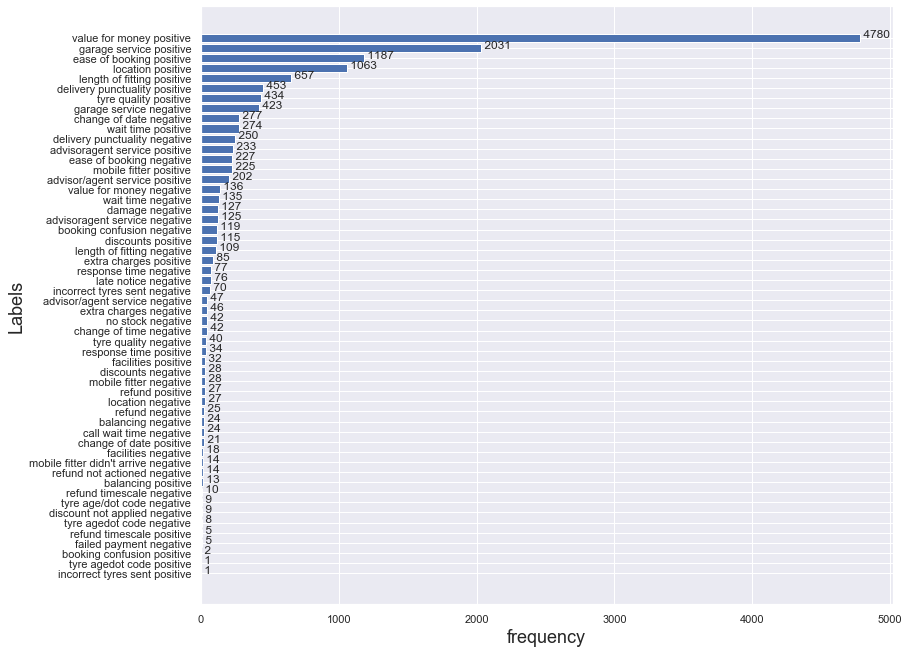

In [10]:
d = dict(Counter(df.target.explode()))
d = {k: v for k, v in sorted(d.items(), key=lambda item: item[1])}

sns.set(rc={'figure.figsize':(12.4,11.00)})
plt.barh(range(len(d)), d.values(), align='center')
plt.yticks(range(len(d)), d.keys())
plt.xlabel('frequency', fontsize=18)
plt.ylabel('Labels', fontsize=18)

for index, value in enumerate(d.values()):
    plt.text(value, index, ' '+str(value))

plt.show()

#### As there are alot of labels that are less than 100, so we can combine them to there respective sentiment labels as due to there low frequecies it will be very difficult for model to learn and we can also there are some labels like 'advisor/agent service positive', 'advisoragent service positive' are same but due to some characters they are split so we can fix this too

In [11]:
def replace_label(df, src, trg):
    def replace(texts):
        return [lab if lab != src else trg for lab in texts]
    
    df['target'] = df['target'].map(replace)
    
def combine_labels(df,min_samples = 100):
    label_counts = df.target.explode().value_counts()
    label_names = label_counts.index
    
    fewer_labels = []
    for i,label in enumerate(label_names):
        if label_counts[i] < min_samples:
            fewer_labels.append(label)
    
    def replace_fewer(labels):
        fewers = []
        for label in labels:
            sentiment = label.split(' ')[-1]
            if label in fewer_labels:
                fewers.append(' '.join(['extra',sentiment]))
            else:
                fewers.append(label)
                
        return fewers 
    
    df['target'] = df['target'].map(replace_fewer)  

    return df

replace_label(df, 'advisor/agent service positive','advisoragent service positive')
replace_label(df, 'advisor/agent service negative','advisoragent service negative')
replace_label(df, 'tyre age/dot code negative','tyre agedot code negative')

df = combine_labels(df)


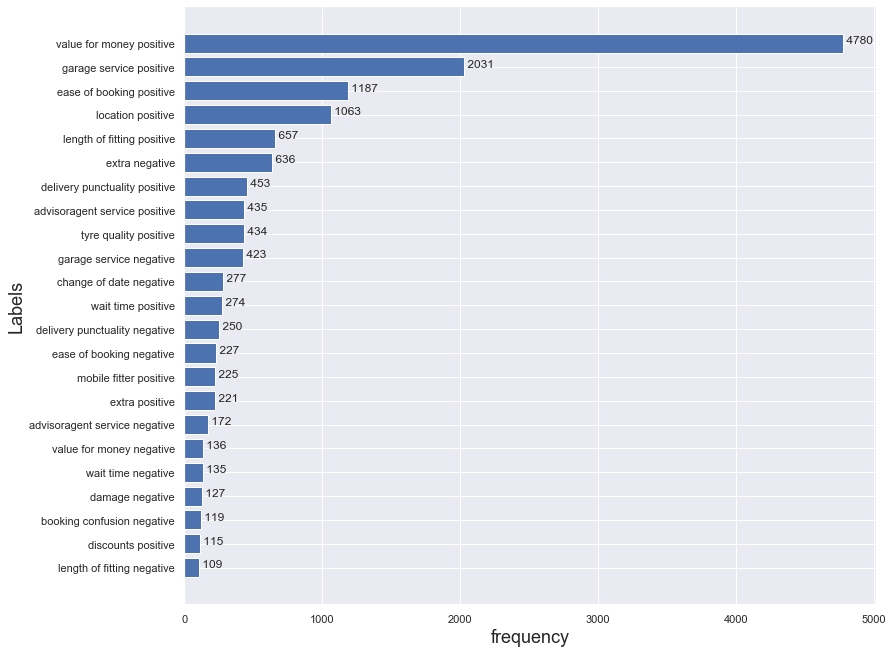

In [12]:
d = dict(Counter(df.target.explode()))
d = {k: v for k, v in sorted(d.items(), key=lambda item: item[1])}

sns.set(rc={'figure.figsize':(12.4,11.00)})
plt.barh(range(len(d)), d.values(), align='center')
plt.yticks(range(len(d)), d.keys())
plt.xlabel('frequency', fontsize=18)
plt.ylabel('Labels', fontsize=18)

for index, value in enumerate(d.values()):
    plt.text(value, index, ' '+str(value))

plt.show()


#### So we have combined all the labels that have frequency less than 100 to 'extra positve' and 'extra negative' and also Labels like 'value for money positive', 'garage service positive' have very large frequency as compared to othere labels we can undersample those 

In [13]:
print("Number of Unique Labels after all processing - {}".format(len(d)))

Number of Unique Labels after all processing - 23


#### After combining less frequent labels and correcting some duplicate labels, we have 23 labels now

## Under Sampling Analysis

In [14]:
print("No. of Rows after removing datapoint with 0 labels and noisy labels - {}".format(df.shape[0]))


No. of Rows after removing datapoint with 0 labels and noisy labels - 8124


### Undersampling Analysis for value for money positive label

In [15]:
udf = df[df.target.apply(lambda x: x == ['value for money positive'])]
print("No. of rows with only 'value for money positive' as Label - {} ".format(udf.shape[0]))


No. of rows with only 'value for money positive' as Label - 2143 


#### There are 2143 datapoints in which there is only one label that is value for money positive, we can directly undersample these

In [16]:
indexesToDrop = udf.index.values
underSampleLabel = udf.sample(frac = 0.1)
df = df.drop(indexesToDrop)
df = df.append(underSampleLabel)
print("No. of rows after undersampling 'value for money positive' - {}".format(df.shape[0]))


No. of rows after undersampling 'value for money positive' - 6195


#### After Removing 90% of single occuring value for money positive label we have 6195 datapoints

### Undersampling Analysis for garage service positive label

In [17]:
udf = df[df.target.apply(lambda x: x == ['garage service positive'])]
print("No. of rows with only 'garage service positive' as Label - {} ".format(udf.shape[0]))


No. of rows with only 'garage service positive' as Label - 558 


#### There are 558 datapoints in which there is only one label that is 'garage service positive', we can directly undersample these

In [18]:
indexesToDrop = udf.index.values
underSampleLabel = udf.sample(frac = 0.2)
df = df.drop(indexesToDrop)
df = df.append(underSampleLabel)
print("No. of rows after undersampling 'garage service positive' - {}".format(df.shape[0]))


No. of rows after undersampling 'garage service positive' - 5749


#### After Removing 80% of single occuring garage service positive label we have 5749 datapoints

### Undersampling Analysis for value for money positive, garage service positive label together

In [19]:
udf = df[df.target.apply(lambda x: x == ['value for money positive','garage service positive'])]
print("No. of rows with both 'value for money positive' and 'garage service positive' as Label - {} ".format(udf.shape[0]))


No. of rows with both 'value for money positive' and 'garage service positive' as Label - 232 


In [20]:
indexesToDrop = udf.index.values
underSampleLabel = udf.sample(frac = 0.2)
df = df.drop(indexesToDrop)
df = df.append(underSampleLabel)
print("No. of rows after undersampling 'value for money positive' and 'garage service positive' together - {}".format(df.shape[0]))


No. of rows after undersampling 'value for money positive' and 'garage service positive' together - 5563


#### After Undersampling of most frequent occuring labels we have 5587 datapoints 

## Final Distribution of Labels

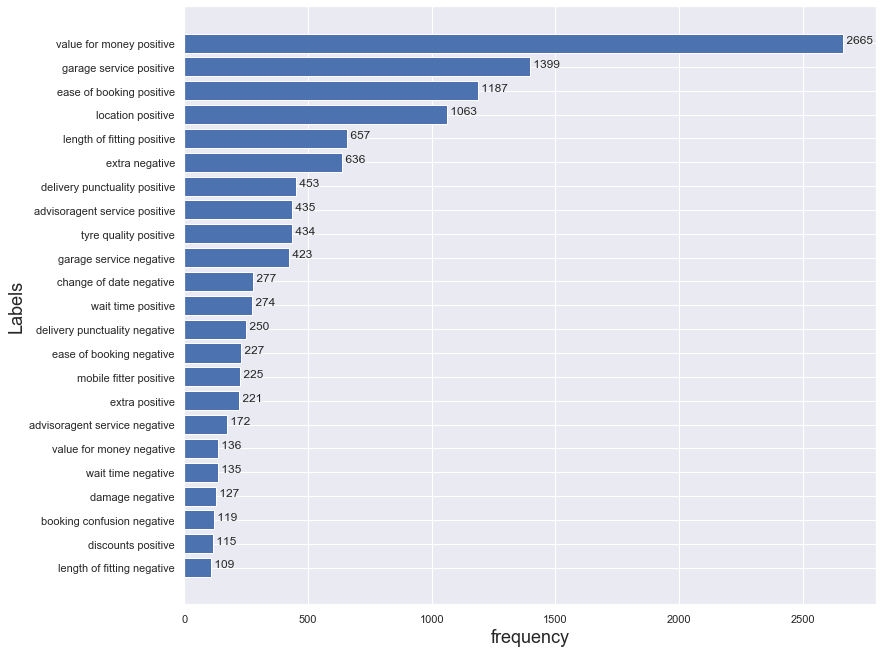

In [21]:
d = dict(Counter(df.target.explode()))
d = {k: v for k, v in sorted(d.items(), key=lambda item: item[1])}

sns.set(rc={'figure.figsize':(12.4,11.00)})
plt.barh(range(len(d)), d.values(), align='center')
plt.yticks(range(len(d)), d.keys())
plt.xlabel('frequency', fontsize=18)
plt.ylabel('Labels', fontsize=18)

for index, value in enumerate(d.values()):
    plt.text(value, index, ' '+str(value))

plt.show()


#### We have reduced the most frequently occuring labels significantly 

## Distibution of Token Lengths of Texts 

<a href="https://ibb.co/2KhkBfF"><img src="https://i.ibb.co/zfx4w0m/token-len-pdf.png" alt="token-len-pdf" border="0"></a>

#### Most of the tokens length will come under 128